In [1]:
import numpy as np
import pandas as pd
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
from jetstream_hugo.hotspells import *

import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/storage/homefs/hb22g102/mambaforge/envs/env1

In [2]:
exp_s = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 250, None, None, None
)
da_s = exp_s.da
exp_s_low = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 700, None, None, None
)
exp_Tmax = Experiment(
    "ERA5", "t", "dailymean", (1940, 2023), [5, 6, 7, 8, 9], -30, 40, 30, 75, 100, 'dayofyear',
    {'dayofyear': ('win', 10)}, None
)
da_Tmax = exp_Tmax.da
da_Tmax = da_Tmax.assign_coords(time=da_Tmax.time.values - pd.Timedelta(9, 'H'))
exp_T = Experiment(
    "ERA5", "t", "6H", "all", "JJA", -30, 40, 30, 75, 250, 'hourofyear', {'hourofyear': ('win', 4 * 10)}, None,
)
da_T = exp_T.da

In [3]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, cut_tree

mask = get_land_mask()

lon, lat = da_T.lon.values, da_T.lat.values
mask = mask.sel(lon=lon, lat=lat)
JA_mask = np.isin(da_T.time.dt.month, [7, 8])
hot_days = da_T[JA_mask] > da_T[JA_mask].quantile(0.95, dim='time')
stack_dims = {'lat_lon': ('lat', 'lon')}
hot_days_flat = hot_days.stack(stack_dims)
mask_flat = mask.stack(stack_dims)
hot_days_flat = hot_days_flat.values[:, mask_flat.values]
distance_path = exp_T.path.joinpath('distances.npy')
try:
    distances = np.load(distance_path)
except FileNotFoundError:
    print('Computing distances')
    distances = pairwise_distances(hot_days_flat.T, metric='jaccard', n_jobs=N_WORKERS)
    np.save(distance_path, distances)
Z = linkage(squareform(distances), method='average')

In [4]:
n_clu = 9
subset = ['Lat', 'Lon', 'Spe', 'lon_ext', 'width', 'tilt', 'sinuosity', 'int', 'persistence']
clusters = cut_tree(Z, n_clusters=n_clu)[:, 0]
clusters_da = np.zeros(mask_flat.shape, dtype=float)
clusters_da[:] = np.nan
clusters_da = mask_flat.copy(data=clusters_da)
clusters_da[mask_flat] = clusters
central_europe = clusters_da.where(clusters_da == 5).unstack()
da_cee = da_T.where(central_europe).mean(dim=['lon', 'lat']).copy()
heat_waves_ts, heat_waves = heat_waves_from_t(
    da_cee, fill_holes=1, time_before=pd.Timedelta(3, 'D'), output_type='list'
)

In [5]:
(
    all_jets,
    where_are_jets,
    all_jets_one_array,
    all_jets_over_time,
    flags,
) = exp_s.track_jets()
flags = xr.DataArray(flags, coords=dict(time=da_s.time.values, jet=np.arange(flags.shape[1])))
props_as_ds_uncat = exp_s.props_as_ds(categorize=False)
props_as_ds_uncat = better_is_polar(all_jets, props_as_ds_uncat, exp_s_low.path)
props_as_ds = categorize_ds_jets(props_as_ds_uncat)
props_as_ds['exists'] = (~props_as_ds['mean_lon'].isnull()).astype(np.float32)

100%|██████████| 51408/51408 [00:24<00:00, 2088.48it/s]


In [40]:
props_as_ds_masked = mask_from_t(da_cee, props_as_ds, q=0.8, fill_holes=True, time_before=pd.Timedelta(4, 'D'))

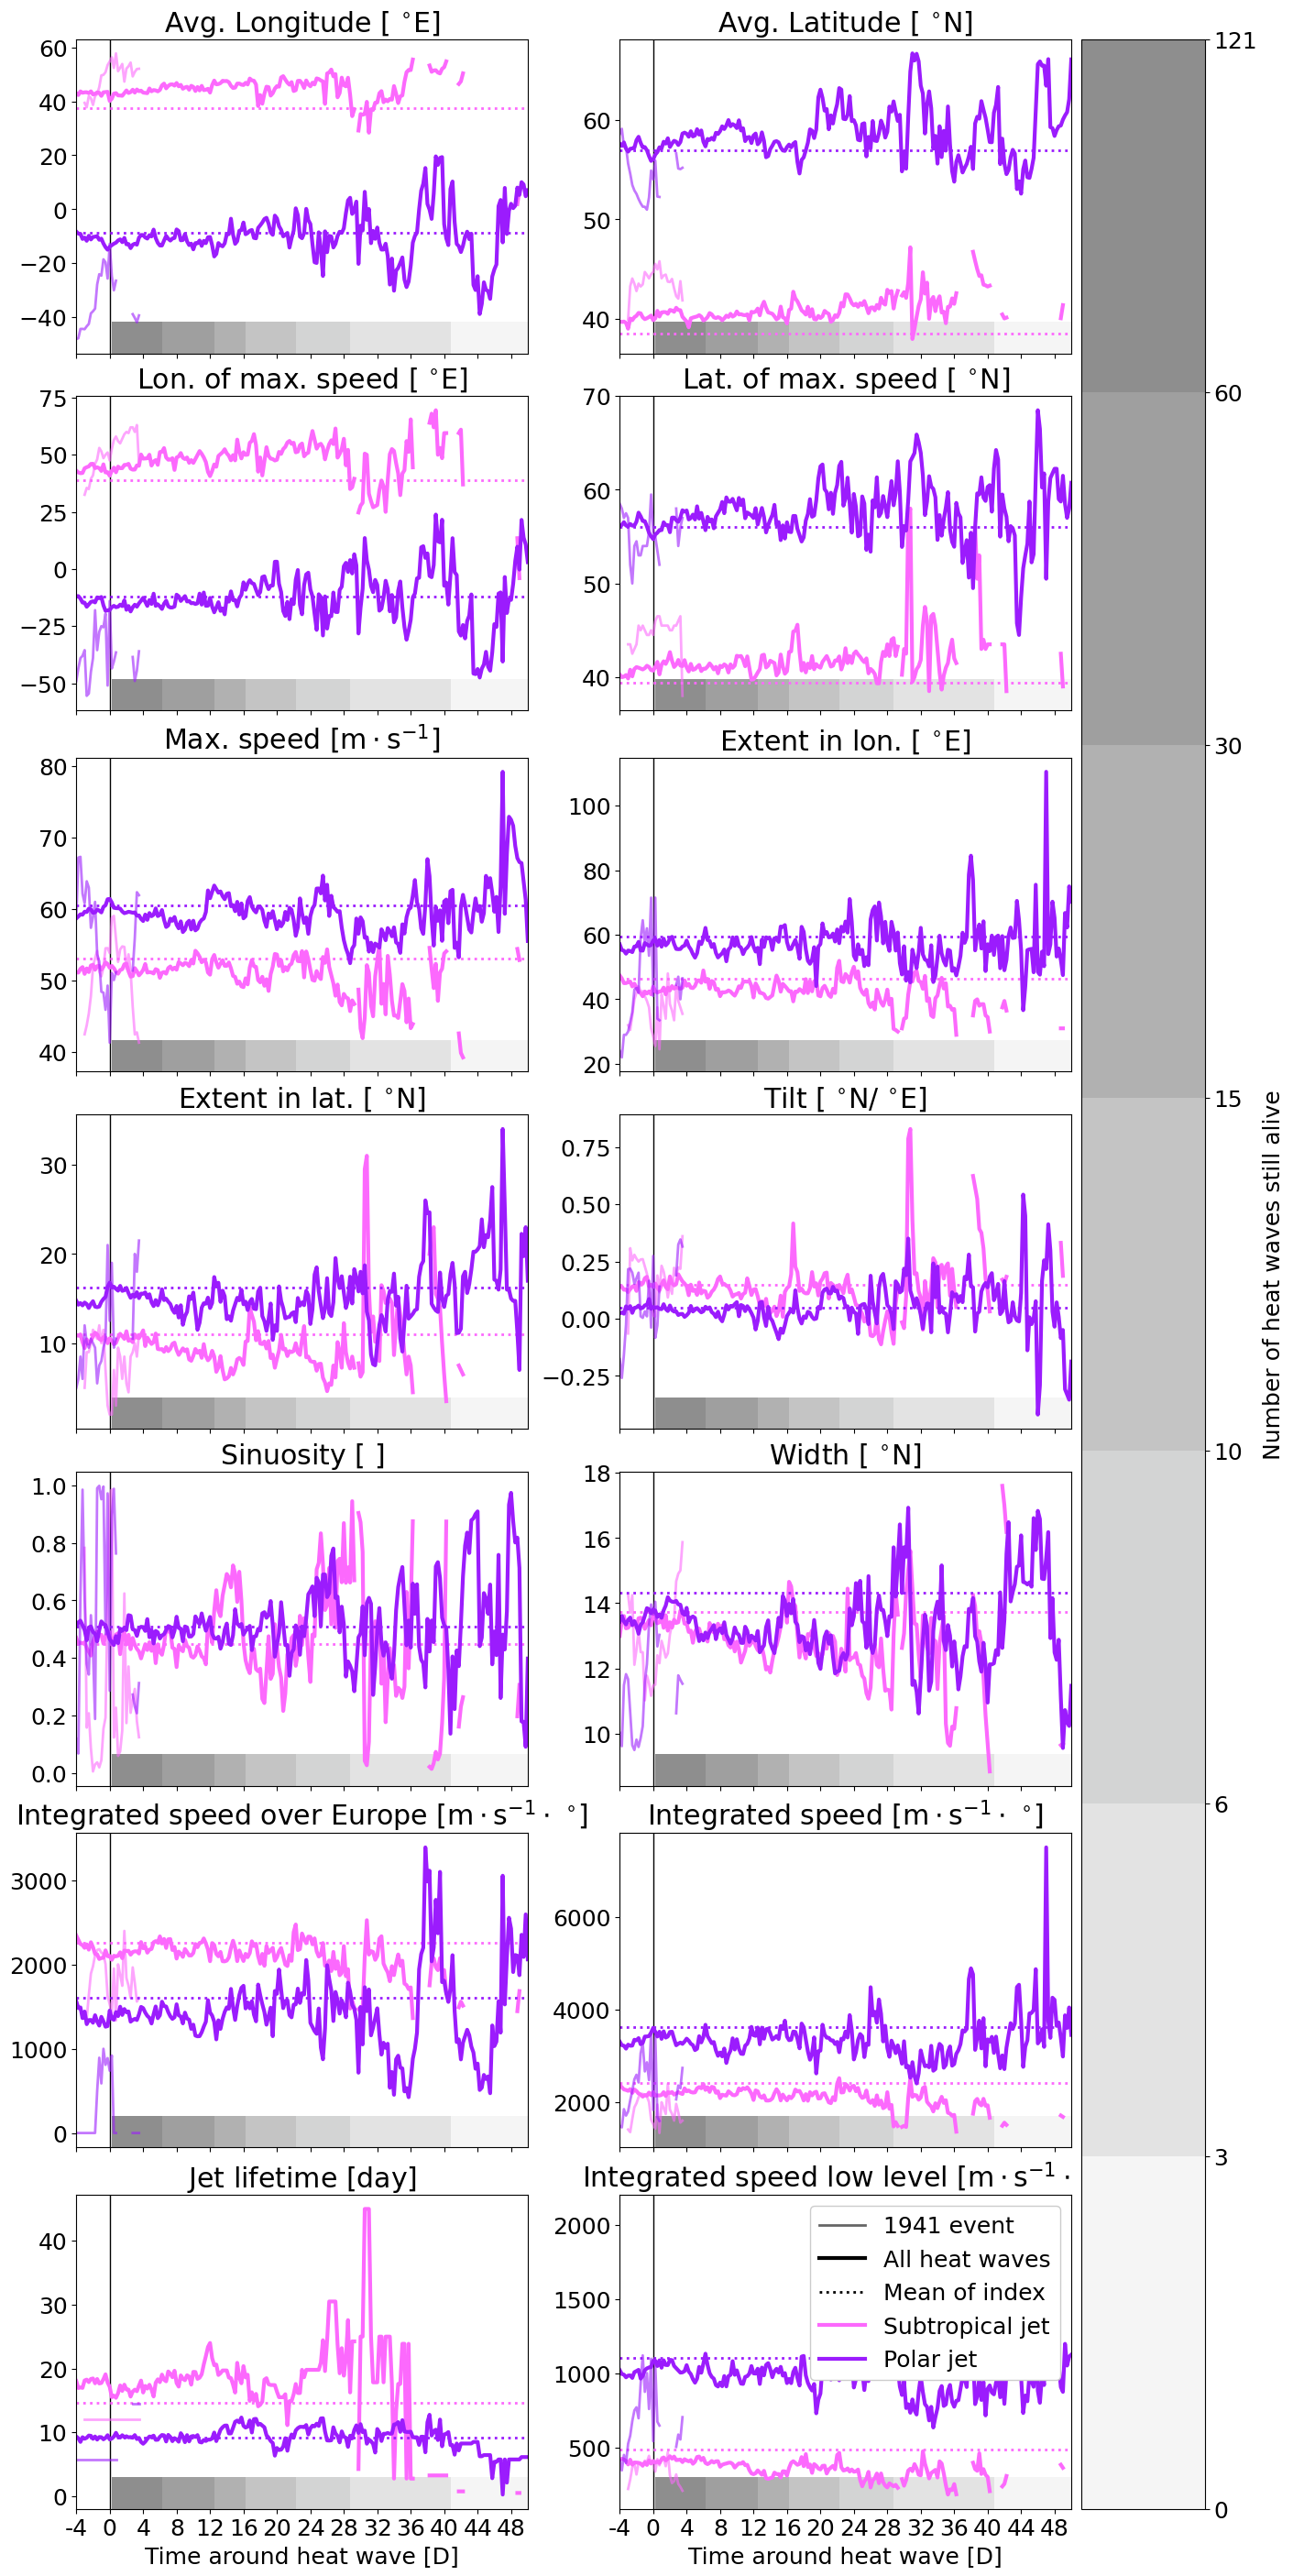

In [45]:
data_vars = list(props_as_ds.data_vars)
fig, axes = plt.subplots(
    len(data_vars) // 2,
    2,
    figsize=(14, len(data_vars) // 2 * 4),
    constrained_layout=True,
    sharex='all'
)
dt = (props_as_ds.time.values[1] - props_as_ds.time.values[0]).astype('timedelta64[h]')
colors = colormaps.cet_l_bmw_r([0.3, 0.55])
n_hotspell = 1
x = props_as_ds_masked.time_around_beg.values.astype('timedelta64[h]')
for varname, ax in zip(data_vars, axes.ravel()):
    for j, jet in enumerate(props_as_ds_masked.jet.values):
        this_da = props_as_ds_masked[varname].loc[..., jet]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mean = this_da.mean(dim='heat_wave').values
        ax.plot(
            x,
            props_as_ds_masked[varname].loc[n_hotspell, :, jet].values.squeeze(),
            color=colors[j], lw=2,
            alpha=0.6,
            ls='solid'
        )
        ax.plot(x, mean, color=colors[j], lw=3, ls='solid')
        mean_all = props_as_ds[varname].sel(jet=jet).mean(dim='time').values
        ax.plot(x, [mean_all] * len(this_da.time_around_beg), color=colors[j], lw=2, ls='dotted')
from matplotlib.lines import Line2D

custom_lines = [
    Line2D([0], [0], color='black', lw=2, linestyle='solid', alpha=0.6),
    Line2D([0], [0], color='black', lw=3, linestyle='solid'),
    Line2D([0], [0], color='black', lw=2, linestyle='dotted'),
    Line2D([0], [0], color=colors[0], lw=3),
    Line2D([0], [0], color=colors[1], lw=3),
]
handles = [
    f'{props_as_ds_masked.absolute_time[n_hotspell, 0].dt.year.values} event', f'All heat waves', f'Mean of index',
    'Subtropical jet',
    'Polar jet'
]
axes.ravel()[-1].legend(custom_lines[:], handles[:], ncol=1, framealpha=1.)
positive_mask = x.astype(int) > 0
alive_hotspells = (~this_da[:, positive_mask].isnull()).sum(dim='heat_wave').values
cmap = colormaps.cet_l_grey_r
cmap = LinearSegmentedColormap.from_list(
    'mod_grey', np.vstack(
        [cmap(np.linspace(0.05, 0.3, 100)), cmap(np.linspace(0.3, 0.6, 100))]
    ), N=200
)
norm = BoundaryNorm([0, 3, 6, 10, 15, 30, 60, alive_hotspells.max()], cmap.N)
ticks = x[::16].astype(int)
xlim = np.amin(x.astype(float)), np.amax(x.astype(float))
ticklabels = x.astype('timedelta64[D]').astype(int)[::16]
for varname, ax in zip(data_vars, axes.ravel()):
    ax.set_title(f'{PRETTIER_VARNAME[varname]} [{UNITS[varname]}]')
    ylim = np.asarray(ax.get_ylim())
    ybounds = ylim[[0, 0]] + np.asarray([0, 0.1 * (ylim[1] - ylim[0])])
    im = ax.pcolormesh(
        x.astype(float)[positive_mask], ybounds, alive_hotspells[None, :-1], zorder=-10, norm=norm,
        cmap=cmap, alpha=0.7
    )
    ax.set_xlim(xlim)
    ax.set_xticks(ticks, ticklabels, ha='center')
    ax.vlines(0, *ylim, color='black', lw=1, ls='solid', zorder=-10)
    ax.set_ylim(ylim)
cbar = fig.colorbar(im, ax=axes, pad=0.01)
_ = cbar.ax.set_ylabel('Number of heat waves still alive')
for ax in axes[-1, :]:
    ax.set_xlabel('Time around heat wave [D]')
plt.savefig(f'{FIGURES}/jet_props_misc/jet_props_vs_hotspell.png', dpi=300)

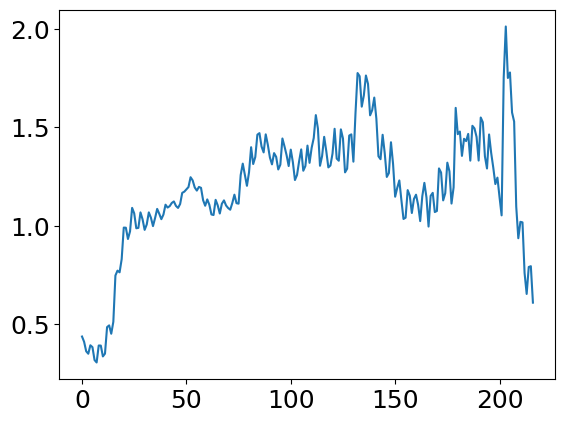

In [46]:
plt.plot(props_as_ds_masked.temperature.mean(dim='heat_wave'))